# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
import pickle
import math

#Set random seed
np.random.seed(1606)

### Functions

In [4]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

### 1. Import Vectors and Pre-Process them

In [5]:
# Import Gofunc vec file
with open('go-gofuncs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [6]:
df.head()

,ID,Vector
0,MESH:D012559,"[-0.14418675, 0.00148405, -0.466548, -0.183814..."
1,MESH:D009404,"[0.00648174, 0.12445401, 0.00781578, -0.099749..."
2,MESH:D001749,"[-0.24630277, 0.03765613, -0.37198013, -0.1262..."
3,MESH:D011471,"[-0.14594647, 0.10092776, -0.7002952, -0.17298..."
4,MESH:D008106,"[-0.30239132, 0.1475905, -0.58684784, -0.19144..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [7]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [8]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [9]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [10]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C028474,MESH:D006528,"[-1.79790407e-01, 2.88105961e-02, -9.71369967e...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1
1,C028474,MESH:D005355,"[-0.01172249, 0.13109156, 0.00888951, -0.15944...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1
2,C028474,MESH:D006529,"[-0.10915242, 0.09243832, -0.04729906, -0.1477...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1
3,C028474,MESH:D006965,"[-2.88997646e-02, 1.38664156e-01, 3.66541967e-...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1
4,C028474,MESH:D008114,"[-0.17260571, 0.03253803, -0.18018836, -0.0771...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1


### Add control (uncorrelated) rows

In [11]:
len(id_list)

3153

In [12]:
chem_dis.shape

(8920, 2)

In [13]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [14]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)   # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  8919
(17839, 5)
(17675, 5)


In [15]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### Add Phenotype Vecs
Got a list of Chem-Phenotypes from Sara Alth, where did these come from originally?
They have CID identifiers (Pubchem). Need to convert CTD ID to CID ID
Use API like so 
http://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/Comparative%20Toxicogenomics%20Database/C533207/cids/TXT/

In [17]:
## First we'll add DOIDs for diseases and CIDs for chemicals as an intermediate for adding phenotypes
# Read in CSV mapping chems to CID and dis to DOID --> This file is created by phens-opa2vec.ipynb
# mapper = pd.read_csv('entities.lst')
mapper = pd.read_csv('chem_dis_to_CID_DOID.csv')

# Make the maps from this
dis_map = dict(zip(mapper.ID, mapper.DOID))
chem_map = dict(zip(mapper.ID, mapper.CID))

# Apply the maps to df1
df1['DOID'] = df1.DiseaseID.map(lambda x: dis_map.get(x))
df1['CID'] = df1.ChemicalID.map(lambda x: chem_map.get(x))

# Switch None to NaN
df1['DOID'] = df1.DOID.map(lambda x: np.nan if x is None else x)

In [18]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID
0,C028474,MESH:D006528,"[-0.179790407, 0.0288105961, -0.0971369967, -0...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,DOID:684,5382.0
1,C028474,MESH:D005355,"[-0.01172249, 0.13109156, 0.00888951, -0.15944...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382.0
2,C028474,MESH:D006529,"[-0.10915242, 0.09243832, -0.04729906, -0.1477...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382.0
3,C028474,MESH:D006965,"[-0.0288997646, 0.138664156, 0.0366541967, -0....","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382.0
4,C028474,MESH:D008114,"[-0.17260571, 0.03253803, -0.18018836, -0.0771...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382.0


In [19]:
# Read in the association files from Sara
dis_phens = pd.read_csv('Disease-PhenotypeAssocation.txt', sep=' ', names=['DOID', 'Phenotype'])
chem_phens =  pd.read_csv('Drug-PhenotypeAssocation.txt', sep=' ', names=['CID', 'Phenotype'])

In [20]:
# The association files have a different format for each ID system than mine, homogenise these
# first chem
def cid_standardiser (cid):
    # Must be format CID + 9 int chars, starting with 1 seemingly
    cid = int(cid)
    output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return output

df1['CID'] = df1.CID.map(lambda x: np.nan if math.isnan(x) else cid_standardiser(x))

In [21]:
# Export the chemical list, this will be used to ensure validation test sets don't overlap with this db
np.savetxt(r'chemsInNN.txt', df1.CID, fmt='%s')

In [25]:
# sider_mod.ChemicalID.unique()# and now disease 
def doid_standardiser (doid):
    # Must be format DOID_ + ...
    # I'm unsure about how well this is working so print out the DOIDs that don't match
    doid = doid.replace(':', '_')
#     output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return doid

df1['DOID'] = df1.DOID.map(lambda x: np.nan if isinstance(x, float) else doid_standardiser(x))

In [26]:
# Don't uncomment, unnceessary
# # Now that the DOIDs and CIDs are theoretically standardised we can chuck in the phens to df1

# # First though check which DOIDs and CIDs do not match up --> SEEMS OK
# test_doids = df1[df1.DOID.map(lambda x: isinstance(x, str))].DOID.tolist()
# imported_doids = dis_phens.DOID.tolist()
# for item in test_doids:
#     if item not in imported_doids:
#         print(item)                            

In [27]:
# Let's create one associations file for each ontology (I believe we need to run HP and MP separately)
chem_phens.columns = ['ID', 'Phen']
dis_phens.columns = ['ID', 'Phen']

# Maps for Split into MP/HP
hp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))
hp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

total_hp = chem_phens[hp_df_crit_c].append(dis_phens[hp_df_crit_d], ignore_index=True)
total_mp = chem_phens[mp_df_crit_c].append(dis_phens[mp_df_crit_d], ignore_index=True)

In [28]:
total_mp.head()

,ID,Phen
0,CID100000085,<http://purl.obolibrary.org/obo/MP_0005036>
1,CID100000085,<http://purl.obolibrary.org/obo/MP_0003360>
2,CID100000085,<http://purl.obolibrary.org/obo/MP_0001636>
3,CID100000085,<http://purl.obolibrary.org/obo/MP_0001363>
4,CID100000085,<http://purl.obolibrary.org/obo/MP_0001664>


In [29]:
# Export the association files and print some stats (more stats later)
np.savetxt(r'associations_hp.txt', total_hp.values, fmt='%s')
np.savetxt(r'associations_mp.txt', total_mp.values, fmt='%s')

print('Num HP associations: ', total_hp.shape[0])
print('Num MP associations: ', total_mp.shape[0])
print('Num ents with MP phen assocs: ', len(total_mp.ID.unique()))
print('Num ents with HP phen assocs: ', len(total_hp.ID.unique()))
print('Num MP associations for just diseases: ', total_mp[total_mp.ID.map(lambda x: 'CID' not in x)].shape[0])
print('Num HP associations for just diseases: ', total_hp[total_hp.ID.map(lambda x: 'CID' not in x)].shape[0])

Num HP associations:  277300
Num MP associations:  111742
Num ents with MP phen assocs:  8942
Num ents with HP phen assocs:  9126
Num MP associations for just diseases:  88633
Num HP associations for just diseases:  193000


In [30]:
# Create entities lists to inform opa2vec which entities we want vectors for
entities = total_mp.ID.unique().tolist()
np.savetxt(r'entities_mp.lst', entities, fmt='%s')

entities = total_hp.ID.unique().tolist()
np.savetxt(r'entities_hp.lst', entities, fmt='%s')

### Run OPA2VEC for entity-phens

In [31]:
# HP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/hp.owl -associations ../msc-thesis/opa/associations_hp.txt -entities ../msc-thesis/opa/entities_hp.lst -outfile ../msc-thesis/opa/hpvecs.lst)', shell=True)

In [32]:
# # MP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/mp.owl -associations ../msc-thesis/opa/associations_mp.txt -entities ../msc-thesis/opa/entities_mp.lst -outfile ../msc-thesis/opa/mpvecs.lst)', shell=True)

In [33]:
# Now import and integrate the vecs (all phen stuff above here should be in its own notebook )
# Import vec file
with open('hpvecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
hp_vecs = pd.DataFrame(text)
hp_vecs.columns = ['ID', 'Vector']

# Clean
hp_vecs = hp_vecs.dropna()
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.split(','))

In [34]:
# Now import and integrate the mp vecs
# Import vec file
with open('mpvecs.lst', 'r') as file:
    text = file.read()

# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
mp_vecs = pd.DataFrame(text)
mp_vecs.columns = ['ID', 'Vector']

# Clean
mp_vecs = mp_vecs.dropna()
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.split(','))

In [35]:
# Right, now I have hp and mp vecs, match them up into df1

In [36]:
# Make Maps:
mp_ent_to_vec = dict(zip(mp_vecs.ID, mp_vecs.Vector))
hp_ent_to_vec = dict(zip(hp_vecs.ID, hp_vecs.Vector))

# Map entities to vecs (one set of vecs for mp and another for hp)
df1['disPhenVecMP'] = df1.DOID.map(lambda x: mp_ent_to_vec.get(x))
df1['disPhenVecHP'] = df1.DOID.map(lambda x: hp_ent_to_vec.get(x))

df1['chemPhenVecHP'] = df1.CID.map(lambda x: hp_ent_to_vec.get(x))
df1['chemPhenVecMP'] = df1.CID.map(lambda x: mp_ent_to_vec.get(x))

In [37]:
## TODO note that I have removed rows without gofuncVecs, maybe now they should be kept
# Print Stats
print('Note these numbers include both correlated and uncorrelated pairs')
print('Number of rows with gofuncs: ', df1.shape[0]) ##NB change this if keeping rows w/o gofunc vecs
print('Number of rows with dis mp vec: ', df1[df1.disPhenVecMP.map(lambda x: x is not None)].shape[0])
print('Number of rows with dis hp vec: ', df1[df1.disPhenVecHP.map(lambda x: x is not None)].shape[0])
print('Number of rows with chem mp vec: ', df1[df1.chemPhenVecMP.map(lambda x: x is not None)].shape[0])
print('Number of rows with chem hp vec: ', df1[df1.chemPhenVecHP.map(lambda x: x is not None)].shape[0])
no_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is None) & df1.disPhenVecMP.map(lambda x: x is None)
no_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is None) & df1.chemPhenVecMP.map(lambda x: x is None)
no_phen_vecs = no_dis_phen_vecs & no_chem_phen_vecs
print('Number of rows with no phen vecs: ', df1[no_phen_vecs].shape[0])
all_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is not None) & df1.disPhenVecMP.map(lambda x: x is not None)
all_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is not None) & df1.chemPhenVecMP.map(lambda x: x is not None)
all_vecs = all_dis_phen_vecs & all_chem_phen_vecs
all_vecs_pos_corr = all_vecs & df1.Correlation.map(lambda x: x == 1)
all_vecs_neg_corr = all_vecs & df1.Correlation.map(lambda x: x == 0)
no_phen_vecs_corr = no_phen_vecs & df1.Correlation.map(lambda x: x == 1)
no_phen_vecs_uncorr = no_phen_vecs & df1.Correlation.map(lambda x: x == 0)



print('Number of rows with everything', df1[all_vecs].shape[0])

print('Number of correlated pairs with phenvecs', df1[no_phen_vecs_corr].shape[0])
print('Number of uncorrelated pairs with phenvecs', df1[no_phen_vecs_uncorr].shape[0])


print('Number of correlated pairs with everything', df1[all_vecs_pos_corr].shape[0])
print('Number of uncorrelated pairs with everything', df1[all_vecs_neg_corr].shape[0])

print('total pos corr', df1[df1.Correlation.map(lambda x: x == 1)].shape[0])
print('total neg corr', df1[df1.Correlation.map(lambda x: x == 0)].shape[0])

Note these numbers include both correlated and uncorrelated pairs
Number of rows with gofuncs:  17675
Number of rows with dis mp vec:  6530
Number of rows with dis hp vec:  6530
Number of rows with chem mp vec:  0
Number of rows with chem hp vec:  0
Number of rows with no phen vecs:  11145
Number of rows with everything 0
Number of correlated pairs with phenvecs 3985
Number of uncorrelated pairs with phenvecs 7160
Number of correlated pairs with everything 0
Number of uncorrelated pairs with everything 0
total pos corr 8869
total neg corr 8806


In [32]:
# Add empty vecs for rows that don't have phen vecs
empty_vec = [0] * 200

for col in ['disPhenVecMP', 'disPhenVecHP', 'chemPhenVecHP', 'chemPhenVecMP']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [33]:
# Change the Phen vec elements from string to floats
df1['disPhenVecHP'] = df1.disPhenVecHP.map(lambda x: [float(i) for i in x])
df1['disPhenVecMP'] = df1.disPhenVecMP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecHP'] = df1.chemPhenVecHP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecMP'] = df1.chemPhenVecMP.map(lambda x: [float(i) for i in x])

### Add CHEBI Vecs

In [34]:
# First add CHEBI IDs for each chem

In [35]:
# chem_names = df1.ChemicalID.unique().tolist()
# np.savetxt(r'chem_names', total_hp.values, fmt='%s')

In [36]:
# To add chebi first need CID for ALL Chems so I made this comprehensive map:
# Load the map from pickle object
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

ctd_cid_map = load_obj('ctd_cid_map')

In [37]:
df1['CID'] = df1.ChemicalID.map(lambda x: ctd_cid_map.get(x))

In [38]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP
12202,C546611,MESH:C536416,"[-0.0125178732, 0.100214429, 0.0269463584, -0....","[0.00723881973, 0.104152687, 0.0443294868, -0....",0,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
818,D003520,MESH:D055370,"[-0.02555947, 0.12397544, 0.02142457, -0.09598...","[-0.05013044, 0.09375505, -0.04860608, -0.1522...",1,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
598,D002994,MESH:D008107,"[-0.12299962, 0.1338947, -0.06364362, -0.15485...","[-0.0287671238, 0.0779850557, -0.138412163, -0...",1,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [39]:
# Convert CIDS from bytes to strings and export in order to make a map from CID to CHEBI ID
df1['CID'] = df1.CID.str.decode("utf-8")
np.savetxt(r'allCIDs.txt', df1.CID.unique(), fmt='%s')

## NOTE the next step is MANUAL you need to upload this allCIDs.txt to http://cts.fiehnlab.ucdavis.edu/batch 
# and download it as ctd_chebi.csv to the current folder

In [40]:
# How many chemicals don't have CIDs? Hence don't get chebi vecs
print(df1.shape[0])
print(df1[df1.CID.map(lambda x: x is not None)].shape[0])

17675
47


In [41]:
# Import CSV mapping CID to CHEBI
ctdChebdf = pd.read_csv('ctd_chebi.csv')

# Turn it into a dict
ctd_chebi = dict(zip(ctdChebdf['PubChem CID'], ctdChebdf['ChEBI']))

# Map the cids to chebis
df1['CHEBI'] = df1.CID.map(lambda x: ctd_chebi.get(x))
df1['CHEBI'] = df1.CHEBI.map(lambda x: None if x == 'No result' else x)

In [42]:
# Now make CHEBI vecs using the CHEBI IDs
# First an association file - just linking each chebi to its own chebi entity

# add uri col
df1['CHEBI_uri'] = df1.dropna(subset=['CHEBI']).CHEBI.map(lambda x: '<http://purl.obolibrary.org/obo/' + x.replace(':', '_') + '>')

# export association file from df
np.savetxt(r'CHEBIassociations.txt', df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().values, fmt='%s')

# Now an entities file
chems_for_cheb = df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().ChemicalID.tolist()
np.savetxt(r'CHEBIentities.txt', chems_for_cheb, fmt='%s')

In [43]:
# Commenting this out now that I already have the vectors, you'll need it if you don't have them
# # Now run opa2vec on it 
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/chebi.owl -associations ../msc-thesis/opa/CHEBIassociations.txt -entities ../msc-thesis/opa/CHEBIentities.txt -outfile ../msc-thesis/opa/chebi-vecs.lst)', shell=True)

In [44]:
# Import Gofunc vec file
with open('chebi-vecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (ChemID to CHEBIvec)
chem_to_chebi_vec = dict(zip(df.ID, df.Vector))

In [45]:
df1['CHEBIvec'] = df1.ChemicalID.map(lambda x: chem_to_chebi_vec.get(x))

In [46]:
chem

'D001629'

In [47]:
# How many rows have CHEBI Vecs?
print('Total Rows', df1.shape[0])
print('Total Correlated Rows', df1[df1.Correlation == 1].shape[0])
print('Total CHEBI vec rows', df1.dropna(subset=['CHEBIvec']).shape[0])
print('Total CHEBI vec correlated rows', df1[df1.Correlation == 1].dropna(subset=['CHEBIvec']).shape[0])
print('Total Chems', len(df1.ChemicalID.unique()))
print('Total Chems with CHEBI Vec', len(df1.dropna(subset=['CHEBIvec']).ChemicalID.unique()))

Total Rows 17675
Total Correlated Rows 8869
Total CHEBI vec rows 5323
Total CHEBI vec correlated rows 3361
Total Chems 586
Total Chems with CHEBI Vec 131


In [48]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec
3296,D052638,MESH:D003865,"[-0.0087598497, 0.108188801, 0.015465837, -0.1...","[0.0086054327, 0.133230567, 0.0581015162, -0.1...",1,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,None
5911,D015032,MESH:D001930,"[-0.0672413334, 0.075782463, -0.0542644635, -0...","[-0.09532133, 0.11754729, -0.0500565, -0.14185...",1,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.01691728, 0.05835598, 0.02028357, -0.054936..."
9754,C059262,MESH:C563236,"[-0.167261198, 0.0433385484, -0.155834004, -0....","[0.00480464054, 0.0560031608, 0.0299276672, -0...",0,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[1.48044415e-02, 6.98268563e-02, 3.20285931e-0..."


In [49]:
# Add empty vecs for rows that don't have Chebi vecs
empty_vec = [0] * 200
df1['CHEBIvec'] = df1['CHEBIvec'].map(lambda x: empty_vec if x is None else x)

# Change the Chebi vec elements from string to floats
df1['CHEBIvec'] = df1.CHEBIvec.map(lambda x: [float(i) for i in x])

### Add DO Vecs

In [50]:
# Import Gofunc vec file
with open('do-vecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [disease, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (DisID to DOvec)
dis_to_DOvec = dict(zip(df.ID, df.Vector))

In [51]:
df1['DOvec'] = df1.DiseaseID.map(lambda x: dis_to_DOvec.get(x))

In [52]:
# print(df1[df1.DOvec])

In [53]:
# Change the DO vec elements from string to floats
df1['DOvec'] = df1.DOvec.map(lambda x: [float(i) for i in x])

### ADD HINO vecs
This file is getting a bit long 

In [54]:
# Import HINO vec file
with open('hinoVecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (DisID to DOvec)
entity_to_HINOvec = dict(zip(df.ID, df.Vector))

In [55]:
df1['dis_HINOvec'] = df1.DiseaseID.map(lambda x: entity_to_HINOvec.get(x))
df1['chem_HINOvec'] = df1.ChemicalID.map(lambda x: entity_to_HINOvec.get(x))

In [56]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
2395,D002104,MESH:D063766,"[-0.0395922884, 0.117196642, -0.0374378189, -0...","[-0.0450000204, 0.104458526, -0.0628507286, -0...",1,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00339590292, 0.0175758395, 0.00584002212, -...","[0.00399537, 0.0472186, 0.02650495, -0.0385949...","[0.01770711, 0.05921594, 0.02581135, -0.049142..."
10064,C009160,MESH:D017681,"[0.00925816875, 0.0955886394, 0.029506959, -0....","[-0.000796198728, 0.108124308, 0.0363571383, -...",0,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0159668569, 0.0704993159, 0.0201660953, -0....",None,None
17442,C079574,OMIM:617408,"[0.0101115583, 0.128337547, 0.0384806953, -0.1...","[-0.01319831, 0.12251377, 0.01218663, -0.15855...",0,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.95073613e-05, 0.0287878234, 0.0110968063, -...","[7.64251128e-03, 3.11027840e-02, 2.01068427e-0...","[0.01569333, 0.05778181, 0.0186248, -0.0604203..."


In [57]:
print('HINO dis vecs: ', df1[df1.dis_HINOvec.map(lambda x: x is not None)].shape[0])
print('HINO chem vecs: ', df1[df1.chem_HINOvec.map(lambda x: x is not None)].shape[0])
at_least_one = df1.chem_HINOvec.map(lambda x: x is not None) | df1.dis_HINOvec.map(lambda x: x is not None)
print('At least one hino vec: ', df1[at_least_one].shape[0])

HINO dis vecs:  11437
HINO chem vecs:  11481
At least one hino vec:  15446


In [58]:
# Add empty vecs in place of None
empty_vec = [0] * 200

for col in ['dis_HINOvec', 'chem_HINOvec']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [59]:
# Change the HINO vec elements from string to floats
df1['dis_HINOvec'] = df1.dis_HINOvec.map(lambda x: [float(i) for i in x])
df1['chem_HINOvec'] = df1.chem_HINOvec.map(lambda x: [float(i) for i in x])

In [60]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
0,C028474,MESH:D006528,"[-0.179790407, 0.0288105961, -0.0971369967, -0...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00669117, 0.06971597, 0.03065702, -0.06519...","[0.0200661421, 0.0846487656, 0.0512406044, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C028474,MESH:D005355,"[-0.01172249, 0.13109156, 0.00888951, -0.15944...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011856921, 0.0321784094, 0.0178192798, -0.0...","[0.0150483958, 0.0510327779, 0.0197701622, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C028474,MESH:D006529,"[-0.10915242, 0.09243832, -0.04729906, -0.1477...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00442429, 0.02501368, 0.01620419, -0.024251...","[0.02016229, 0.07256906, 0.04411869, -0.085400...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C028474,MESH:D006965,"[-0.0288997646, 0.138664156, 0.0366541967, -0....","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00854880922, 0.0434569977, 0.0188593101, -0...","[0.01586598, 0.04570289, 0.01966096, -0.046161...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C028474,MESH:D008114,"[-0.17260571, 0.03253803, -0.18018836, -0.0771...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00712068, 0.03850456, 0.01660043, -0.036797...","[0.0202902, 0.0923401, 0.03814096, -0.09578727...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [61]:
print(df1[df1.Correlation == 1].shape[0])
print(df1.shape)

8869
(17675, 17)


In [62]:
df1.sample(2)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
7211,D007854,MESH:D048629,"[-0.00360353, 0.10126243, 0.04305216, -0.11398...","[-0.06867973, 0.1204514, 0.03725361, -0.116115...",1,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01017333, 0.02555509, 0.01003362, -0.035466...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00320454617, 0.0361537449, 0.0250376482, -0..."
3584,D014635,MESH:D007859,"[-0.05899714, 0.10310849, 0.0072578, -0.097280...","[-0.09201236, 0.06609955, -0.13402744, -0.1180...",1,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0243733507, 0.0613955259, 0.0312294979, -0....","[0.019068381, 0.03154701, 0.016168145, -0.0357...","[0.02416604, 0.0857874, 0.0369802, -0.08958978..."


In [63]:
# # Version for phen and gofunc vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [64]:
# Version for just gofunc vecs
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [65]:
# ## Version for Chebi vecs with gofuncs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# all_X = gofuncs.merge(CHEBvecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [66]:
# # ## Version for just CHEBI vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = np.array(CHEBvecs)

In [67]:
# # Version for GoFuncs, Phens, CHEBI
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [68]:
# # Version for GoFuncs, Phens, CHEBI, DO incl chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [69]:
# # Version for GoFuncs, Phens, CHEBI, DO EXCL chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [70]:
# # Version for GoFuncs, Phens, CHEBI, DO, HINO, -- EXCL chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(df1.dis_HINOvec.values.tolist(), index=df1.index)
# cHINOvecs = pd.DataFrame(df1.chem_HINOvec.values.tolist(), index=df1.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [71]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [72]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (17675,)
X shape:  (17675, 400)


In [73]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [74]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
0,C028474,MESH:D006528,"[-0.179790407, 0.0288105961, -0.0971369967, -0...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00669117, 0.06971597, 0.03065702, -0.06519...","[0.0200661421, 0.0846487656, 0.0512406044, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C028474,MESH:D005355,"[-0.01172249, 0.13109156, 0.00888951, -0.15944...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011856921, 0.0321784094, 0.0178192798, -0.0...","[0.0150483958, 0.0510327779, 0.0197701622, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C028474,MESH:D006529,"[-0.10915242, 0.09243832, -0.04729906, -0.1477...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00442429, 0.02501368, 0.01620419, -0.024251...","[0.02016229, 0.07256906, 0.04411869, -0.085400...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C028474,MESH:D006965,"[-0.0288997646, 0.138664156, 0.0366541967, -0....","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00854880922, 0.0434569977, 0.0188593101, -0...","[0.01586598, 0.04570289, 0.01966096, -0.046161...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C028474,MESH:D008114,"[-0.17260571, 0.03253803, -0.18018836, -0.0771...","[-0.04686837, 0.11625388, 0.01462597, -0.10324...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00712068, 0.03850456, 0.01660043, -0.036797...","[0.0202902, 0.0923401, 0.03814096, -0.09578727...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [75]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  586
number of dis:  2508
352 117 117


In [76]:
# # Export the chemical list, this will be used to ensure validation test sets don't overlap with this db
# np.savetxt(r'chemsInNN.txt', chems, fmt='%s')

In [77]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [78]:
# Split by CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

number of chemicals:  586
number of dis:  2508


In [79]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

10727 3596 3352


In [80]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

### 3. Establish NN Model

In [81]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Flatten(input_shape=[400]),
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(60, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [82]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [83]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [84]:
# 3. Train
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 10727 samples, validate on 3352 samples
Epoch 1/5
10727/10727 [==============================] - 1s 94us/step - loss: 0.5413 - acc: 0.7378 - val_loss: 0.5325 - val_acc: 0.7524
Epoch 2/5
10727/10727 [==============================] - 1s 72us/step - loss: 0.5097 - acc: 0.7602 - val_loss: 0.5289 - val_acc: 0.7470
Epoch 3/5
10727/10727 [==============================] - 1s 76us/step - loss: 0.5019 - acc: 0.7694 - val_loss: 0.5310 - val_acc: 0.7467
Epoch 4/5
10727/10727 [==============================] - 1s 76us/step - loss: 0.4921 - acc: 0.7696 - val_loss: 0.5553 - val_acc: 0.7399
Epoch 5/5
10727/10727 [==============================] - 1s 77us/step - loss: 0.4797 - acc: 0.7799 - val_loss: 0.5292 - val_acc: 0.7509


### ...and evaluate

In [85]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3596/3596 [==============================] - 0s 33us/step
Test accuracy: 0.7355394882540549


In [86]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       1318   451     1769
True         500  1327     1827
__all__     1818  1778     3596


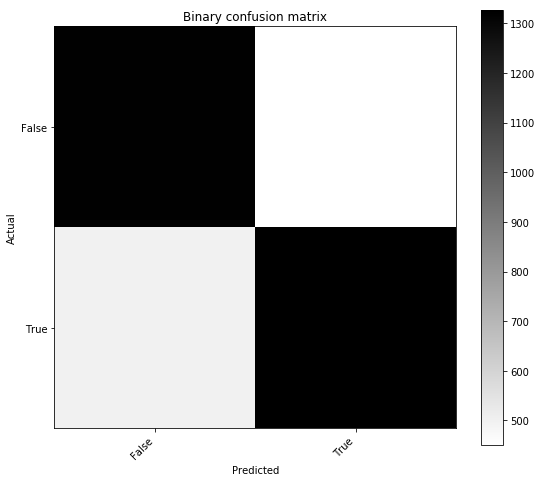

In [87]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [88]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8045788271709793


## Validation Sider

In [89]:
# sider_mod = pd.read_csv('../validation/Sider_val.csv')

In [90]:
# # Need to turn all to float
# import ast

# all_vecs = ['ChemGoVec', 'DisGoVec', 'disPhenVecMP', 'disPhenVecHP', 'CHEBIvec', 'DOvec', 
#             'dis_HINOvec', 'chem_HINOvec', ]

# for col in all_vecs:
#     sider_mod[col] = [ast.literal_eval(x) for x in sider_mod[col]]
#     sider_mod[col] = sider_mod[col].map(lambda x: [float(i) for i in x])

In [91]:
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(sider_mod.DisGoVec.values.tolist(), index= sider_mod.index)
# Cvecs = pd.DataFrame(sider_mod.ChemGoVec.values.tolist(), index= sider_mod.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(sider_mod.disPhenVecHP.values.tolist(), index= sider_mod.index)
# DHPvecs = pd.DataFrame(sider_mod.disPhenVecMP.values.tolist(), index= sider_mod.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(sider_mod.CHEBIvec.values.tolist(), index = sider_mod.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(sider_mod.DOvec.values.tolist(), index = sider_mod.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(sider_mod.dis_HINOvec.values.tolist(), index=sider_mod.index)
# cHINOvecs = pd.DataFrame(sider_mod.chem_HINOvec.values.tolist(), index=sider_mod.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [92]:
# Version for just gofunc vecs
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:

Dvecs = pd.DataFrame(sider_mod.DisGoVec.values.tolist(), index= sider_mod.index)
Cvecs = pd.DataFrame(sider_mod.ChemGoVec.values.tolist(), index= sider_mod.index)
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

NameError: name 'sider_mod' is not defined

In [ ]:
# Now create np array of the y output
all_y = np.array(sider_mod.Correlation)

In [ ]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

In [ ]:
# Accuracy
test_loss, test_acc = model.evaluate(all_X, all_y)
print('Test accuracy:', test_acc)

In [ ]:
# Get predictions
predictions = model.predict(all_X)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

In [ ]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(all_y, predictions))

In [ ]:
print('Chems :', sider_mod.ChemicalID.nunique())
print('Dis :', sider_mod.MESH.nunique())
print('chem:dis obs: ', sider_mod.shape[0])
print('of which are uncorrelated: ', sider_mod[sider_mod.Correlation == 0].shape[0])

In [ ]:
# Error out to stop notebook
for a in i
def 


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# test_set.DiseaseID.nunique()

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    print(col,  df_cd.columns)
    if str(col) in df_cd.columns: print('sd') # df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')

In [ ]:
mem_usage(df_cd)

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
# lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
# del lst
# test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
# for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
#     if col in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
#     if col in test_set.columns: test_set[col] = test_set[col].astype('category')

test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
type(df_cd.ChemicalID[1])

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions']].to_csv('predictions.csv', index=False)

In [ ]:
test_set.head()

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

In [ ]:
test_set.head()

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similarity

In [ ]:
# df1.head()

In [ ]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# Save entire model to a HDF5 file
model.save('nn020219auc907.h5')

In [ ]:
# Save model (in two files, one for weights and one for json)
json_string = model.to_json()
model.save_weights("WEIGHTSnn020219auc907.h5")
with open('nn020219auc907.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [ ]:
from tensorflow.keras.models import load_model

model.save('nn020219auc907.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('nn020219auc907.h5')

In [ ]:
tf.default_session()

In [ ]:
from tensorflow.python.saved_model import tag_constants

with tf.Graph().as_default():
    with tf.Session as sess:
        ...

        # Saving
        inputs = {
            "batch_size_placeholder": batch_size_placeholder,
            "features_placeholder": features_placeholder,
            "labels_placeholder": labels_placeholder,
        }
        outputs = {"prediction": model_output}
        tf.saved_model.simple_save(
            sess, './', inputs, outputs
        )

In [ ]:
w1 = tf.Variable(tf.truncated_normal(shape=[10]), name='w1')
w2 = tf.Variable(tf.truncated_normal(shape=[20]), name='w2')
tf.add_to_collection('vars', w1)
tf.add_to_collection('vars', w2)
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, 'my-model')
# `save` method will call `export_meta_graph` implicitly.
# you will get saved graph files:my-model.meta